<a href="https://colab.research.google.com/github/AdhamDakak/Customer-Lifetime-Value-Prediction/blob/main/Customer_Lifetime_Value_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns

In [130]:
#reading dataset
df=pd.read_csv('scanner_data.csv',
 parse_dates = ["Date"],
 date_format="%d/%m/%Y")
df.drop('Unnamed: 0',inplace=True,axis=1)
df.head()

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,2016-01-02,2547,1,X52,0EM7L,1.0,3.13
1,2016-01-02,822,2,2ML,68BRQ,1.0,5.46
2,2016-01-02,3686,3,0H2,CZUZX,1.0,6.35
3,2016-01-02,3719,4,0H2,549KK,1.0,5.59
4,2016-01-02,9200,5,0H2,K8EHH,1.0,6.88


In [131]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            131706 non-null  datetime64[ns]
 1   Customer_ID     131706 non-null  int64         
 2   Transaction_ID  131706 non-null  int64         
 3   SKU_Category    131706 non-null  object        
 4   SKU             131706 non-null  object        
 5   Quantity        131706 non-null  float64       
 6   Sales_Amount    131706 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 7.0+ MB


In [132]:
#drop null values if exists
df.dropna()

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,2016-01-02,2547,1,X52,0EM7L,1.0,3.13
1,2016-01-02,822,2,2ML,68BRQ,1.0,5.46
2,2016-01-02,3686,3,0H2,CZUZX,1.0,6.35
3,2016-01-02,3719,4,0H2,549KK,1.0,5.59
4,2016-01-02,9200,5,0H2,K8EHH,1.0,6.88
...,...,...,...,...,...,...,...
131701,2016-07-04,20203,32900,IEV,FO112,3.0,6.46
131702,2016-07-04,20203,32900,N8U,I36F2,1.0,4.50
131703,2016-07-04,20203,32900,U5F,4X8P4,1.0,5.19
131704,2016-07-04,20203,32900,0H2,ZVTO4,1.0,4.57


In [133]:
#creating clv dataframe with some features
df["Unit_Price"] = df["Sales_Amount"] / df["Quantity"]


clv = df.groupby('Customer_ID').agg({
                                     'Transaction_ID': lambda x: x.nunique(),
                                        'Sales_Amount': lambda x: x.sum(),
                                     'Date':lambda date:(date.max()-date.min()).days
                                     })

clv.columns = ['total_transaction', 'total_price','recency']

clv.head()



,total_transaction,total_price,recency
Customer_ID,,,
1,1,16.29,0
2,2,22.77,87
3,1,10.92,0
4,2,33.29,121
5,5,78.82,147


In [134]:
#getting the customer lifetime value (clv)
clv['average_purchase_value']=clv['total_price']/clv['total_transaction']
total_number_of_customers=clv.shape[0] #number of customers
clv['purchase_frequency']=clv['total_transaction']/total_number_of_customers
repeate_rate=clv[clv['total_transaction']>1].shape[0]/total_number_of_customers
churn_rate=1-repeate_rate
#set profit margin as 15%
clv['profit_margin']=clv['total_price']*0.15
clv['customer_value']=clv['average_purchase_value']*clv['purchase_frequency']
clv['cltv']=(clv['customer_value']/churn_rate)* clv['profit_margin']
clv.head()

,total_transaction,total_price,recency,average_purchase_value,purchase_frequency,profit_margin,customer_value,cltv
Customer_ID,,,,,,,,
1,1,16.29,0,16.290,0.000044,2.4435,0.000720,0.003451
2,2,22.77,87,11.385,0.000088,3.4155,0.001006,0.006742
3,1,10.92,0,10.920,0.000044,1.6380,0.000483,0.001551
4,2,33.29,121,16.645,0.000088,4.9935,0.001471,0.014411
5,5,78.82,147,15.764,0.000221,11.8230,0.003484,0.080788


In [135]:
#dividing customers into chunks
clv['chunks']=pd.qcut(clv['cltv'],4,labels=['Class D','Class C','Class B','Class A'])
clv.sort_values(by='cltv',ascending=False).head()

,total_transaction,total_price,recency,average_purchase_value,purchase_frequency,profit_margin,customer_value,cltv,chunks
Customer_ID,,,,,,,,,
17471,62,3985.94,274,64.289355,0.002740,597.8910,0.176174,206.602311,Class A
17104,55,3844.97,293,69.908545,0.002431,576.7455,0.169943,192.247000,Class A
17294,39,3798.39,277,97.394615,0.001724,569.7585,0.167885,187.617251,Class A
15540,38,2900.61,262,76.331842,0.001680,435.0915,0.128204,109.408821,Class A
15677,25,2765.16,273,110.606400,0.001105,414.7740,0.122217,99.429257,Class A


In [165]:
clv['month_yr'] = df['Date'].apply(lambda x: x.strftime('%b-%Y'))
df.head()

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,Unit_Price,month_yr
0,2016-01-02,2547,1,X52,0EM7L,1.0,3.13,3.13,Jan-2016
1,2016-01-02,822,2,2ML,68BRQ,1.0,5.46,5.46,Jan-2016
2,2016-01-02,3686,3,0H2,CZUZX,1.0,6.35,6.35,Jan-2016
3,2016-01-02,3719,4,0H2,549KK,1.0,5.59,5.59,Jan-2016
4,2016-01-02,9200,5,0H2,K8EHH,1.0,6.88,6.88,Jan-2016


In [169]:
sale = df.pivot_table(index=['Customer_ID'], columns=['month_yr'], values='Sales_Amount', aggfunc='sum', fill_value=0).reset_index()
sale['CLV'] = sale.iloc[:, 2:].sum(axis=1)
sale.head()

month_yr,Customer_ID,Apr-2016,Aug-2016,Dec-2016,Feb-2016,Jan-2016,Jul-2016,Jun-2016,Mar-2016,May-2016,Nov-2016,Oct-2016,Sep-2016,CLV
0,1,0.0,0.0,0.0,0.00,16.29,0.00,0.0,0.00,0.00,0.0,0.0,0.0,16.29
1,2,0.0,0.0,0.0,0.00,0.00,0.00,15.0,7.77,0.00,0.0,0.0,0.0,22.77
2,3,0.0,0.0,0.0,0.00,10.92,0.00,0.0,0.00,0.00,0.0,0.0,0.0,10.92
3,4,0.0,0.0,0.0,0.00,0.00,6.69,0.0,0.00,0.00,26.6,0.0,0.0,33.29
4,5,0.0,0.0,0.0,40.26,0.00,7.06,0.0,17.17,14.33,0.0,0.0,0.0,78.82


<ipython-input-176-db39425d9f37>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sale['CLV'],kde=True)


<Axes: xlabel='CLV', ylabel='Density'>

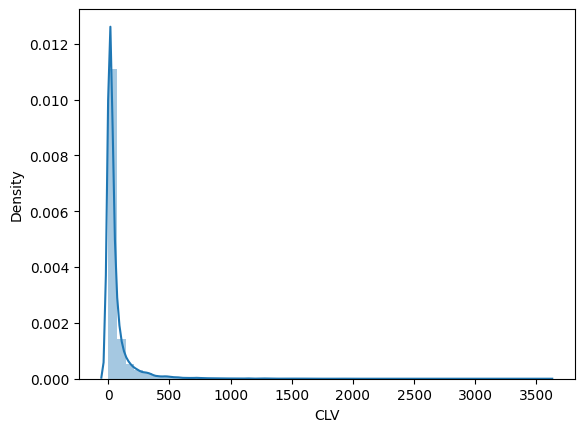

In [176]:
#exploring clv
sns.distplot(sale['CLV'],kde=True)


In [177]:
#selecting dependent and independent variables
X = sale[['Jan-2016', 'Feb-2016', 'Mar-2016', 'Apr-2016', 'May-2016', 'Jun-2016']]
y = sale[['CLV']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [180]:
#predicting training data
training_prediction=regressor.predict(X_train)

In [183]:
r_squared=metrics.r2_score(y_train,training_prediction)
print('R squared error:',r_squared)
mse=mean_squared_error(y_train,training_prediction)
print('mean sqared error: ',mse)
mae=mean_absolute_error(y_train,training_prediction)
print('mean absolute error: ',mae)

R squared error: 0.6855670331505481
mean sqared error:  6150.567286975779
mean absolute error:  37.29147518407801


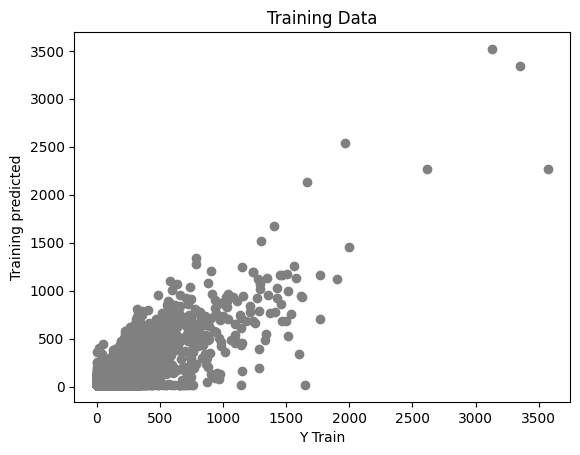

In [190]:
plt.scatter(y_train, training_prediction, color='gray')
plt.title('Training Data')
plt.xlabel('Y Train')
plt.ylabel('Training predicted')
plt.show()

In [186]:
#predicting testing data
testing_prediction=regressor.predict(X_test)

In [187]:
r_squared=metrics.r2_score(y_test,testing_prediction)
print('R squared error:',r_squared)
mse=mean_squared_error(y_test,testing_prediction)
print('mean sqared error: ',mse)
mae=mean_absolute_error(y_test,testing_prediction)
print('mean absolute error: ',mae)

R squared error: 0.6538512265605064
mean sqared error:  6668.1850801291175
mean absolute error:  38.13911673802275


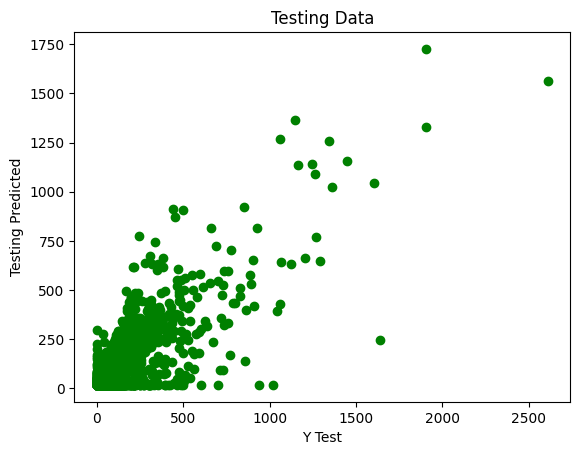

In [191]:
plt.scatter(y_test, testing_prediction, color='green')
plt.title('Testing Data')
plt.xlabel('Y Test')
plt.ylabel('Testing Predicted')
plt.show()